### GP with marathon data using GPytorch
Reference: https://github.com/fonnesbeck/gp_regression/blob/master/notebooks/marathon_times.ipynb

In [1]:
import pandas as pd
import math
import torch
import gpytorch as gpt
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
marathon_results = pd.read_csv('../data/marathon_results_2015.csv', index_col=0)[['Age', 'M/F', 'Official Time']]
marathon_results['time_hours'] = pd.to_timedelta(marathon_results['Official Time']).dt.seconds / 3600
marathon_results['female'] = marathon_results['M/F']=='F'
marathon_results = marathon_results[['Age', 'female', 'time_hours']].rename({'Age':'age'}, axis=1)
print(marathon_results.shape)
marathon_results.head()

(26598, 3)


,age,female,time_hours
0,25,False,2.154722
1,30,False,2.163333
2,29,False,2.172778
3,28,False,2.179722
4,32,False,2.180278


In [3]:
# Filter data
marathon_results = marathon_results[marathon_results.female==True].sample(n=600)
marathon_results.shape

(600, 3)

/home/danph/Repos/win_ssd/oss/gp_experiments/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


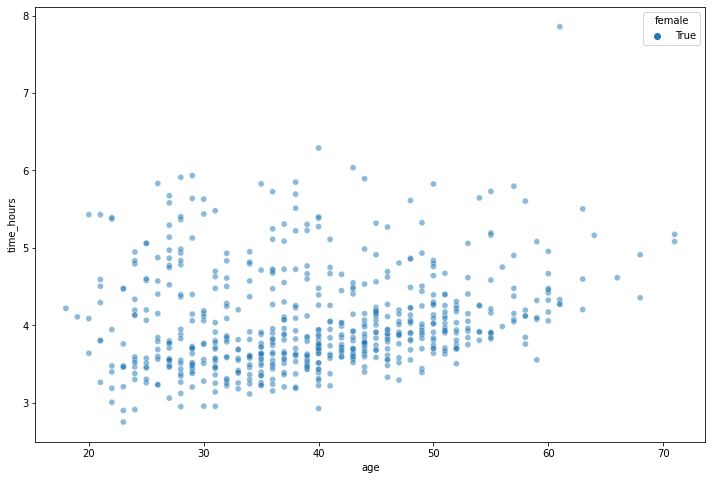

In [4]:
plt.figure(figsize=(12,8))
sns.scatterplot('age', 'time_hours', hue='female', data=marathon_results, alpha=0.5);

In [5]:
marathon_results.loc[marathon_results.female==True, ['age', 'time_hours']].shape

(600, 2)

In [6]:
# Get small sample of dataset
X, y = marathon_results.loc[:, ['age', 'time_hours']].values.T
X.shape, y.shape,  X.mean(), y.mean()

((600,), (600,), 39.52333333333333, 4.044360648148148)

In [7]:
train_x, train_y = torch.tensor(X), torch.tensor(y)
train_x.shape, train_y.shape

(torch.Size([600]), torch.Size([600]))

### Setting up the model

In [8]:
# A basic GP model with exact inference

class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ConstantMean()
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())
        
    def forward(self, x):
        #set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood(
    noise_constraint=gpt.constraints.GreaterThan(1e-2),
)
model = ExactGPModel(train_x, train_y, likelihood)

In [9]:
model.mean_module, model.covar_module

(ConstantMean(),
 ScaleKernel(
   (base_kernel): RBFKernel(
     (raw_lengthscale_constraint): Positive()
   )
   (raw_outputscale_constraint): Positive()
 ))

### Training the model

In [10]:
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - The marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)
X
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.660   lengthscale: 0.693   noise: 0.703
Iter 2/100 - Loss: 1.563   lengthscale: 0.744   noise: 0.654
Iter 3/100 - Loss: 1.480   lengthscale: 0.798   noise: 0.608
Iter 4/100 - Loss: 1.410   lengthscale: 0.853   noise: 0.565
Iter 5/100 - Loss: 1.350   lengthscale: 0.909   noise: 0.524
Iter 6/100 - Loss: 1.301   lengthscale: 0.967   noise: 0.486
Iter 7/100 - Loss: 1.260   lengthscale: 1.026   noise: 0.451
Iter 8/100 - Loss: 1.226   lengthscale: 1.085   noise: 0.420
Iter 9/100 - Loss: 1.200   lengthscale: 1.144   noise: 0.394
Iter 10/100 - Loss: 1.179   lengthscale: 1.204   noise: 0.372
Iter 11/100 - Loss: 1.162   lengthscale: 1.263   noise: 0.356
Iter 12/100 - Loss: 1.147   lengthscale: 1.321   noise: 0.346
Iter 13/100 - Loss: 1.134   lengthscale: 1.379   noise: 0.341
Iter 14/100 - Loss: 1.122   lengthscale: 1.436   noise: 0.341
Iter 15/100 - Loss: 1.111   lengthscale: 1.492   noise: 0.345
Iter 16/100 - Loss: 1.100   lengthscale: 1.547   noise: 0.351
Iter 17/100 - Los

In [11]:
# View model hyper parameters after training
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -0.7647427320480347
Parameter name: mean_module.constant                       value = 3.37807035446167
Parameter name: covar_module.raw_outputscale               value = 1.6500118970870972
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 3.4870684146881104


### Make predictions with the model

In [12]:
# Get into evaluation - posterior predictive - mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpt.settings.fast_pred_var():
    test_x = torch.tensor(X)
    observed_pred = likelihood(model(test_x))

/home/danph/Repos/win_ssd/oss/gp_experiments/.venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [13]:
with torch.no_grad():
    f_preds = model(test_x)

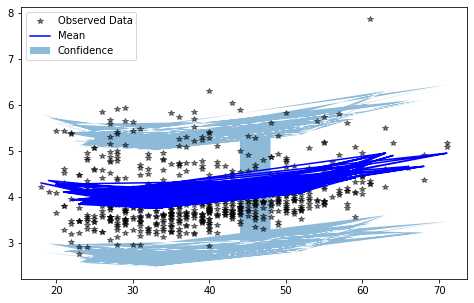

In [14]:
with torch.no_grad():
    f, ax = plt.subplots(1,1,figsize=(8,5))
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', alpha=0.5)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3,3])
    ax.legend(["Observed Data", "Mean", "Confidence"])